# Gradient Boosting Machines demo with XGBoost
Based on this GBM Intro Talk: https://github.com/szilard/GBM-intro

Slides: https://docs.google.com/presentation/d/1WdQajKNeJR5gJs437XUuLksBJPm4rowdzH3i1vEWTHA/edit#slide=id.g5d32535d9c_1_97

Original data set & data dictionary: http://stat-computing.org/dataexpo/2009/the-data.html

Alternate download location: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/HG7NV7

* note for later: sparse DF can improve performance by 10x!!! Verify this.

## Purpose
This demo is an intro to GBM and its high performance.  This model predicts which flights are delayed at least 15 mins based on flight times, carriers, locations, etc.  The 'dep_delayed_15min' column is our target/y values.

# Get Data

In [43]:
import pandas as pd
from sklearn import preprocessing
from scipy import sparse
import numpy as np
import xgboost as xgb
from sklearn import metrics
import matplotlib.pyplot as plt

# Get data
df_train = pd.read_csv("https://s3.amazonaws.com/benchm-ml--main/train-0.1m.csv")
df_test = pd.read_csv("https://s3.amazonaws.com/benchm-ml--main/test.csv")

df_train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


# Preprocess data

In [35]:
print(f'train shape: {df_train.shape}')
print(f'test shape: {df_test.shape}')

df_all = pd.concat([df_train, df_test])
df_all.info()

train shape: (100000, 9)
test shape: (100000, 9)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              200000 non-null  object
 1   DayofMonth         200000 non-null  object
 2   DayOfWeek          200000 non-null  object
 3   DepTime            200000 non-null  int64 
 4   UniqueCarrier      200000 non-null  object
 5   Origin             200000 non-null  object
 6   Dest               200000 non-null  object
 7   Distance           200000 non-null  int64 
 8   dep_delayed_15min  200000 non-null  object
dtypes: int64(2), object(7)
memory usage: 15.3+ MB


In [20]:
vars_cat = ['Month', 'DayofMonth', 'DayOfWeek',  'UniqueCarrier', 'Origin', 'Dest']
vars_num = ['DepTime', 'Distance']

# Encode categorical values
le = preprocessing.LabelEncoder()
for col in vars_cat:
    df_all[col] = le.fit_transform(df_all[col])

df_all.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,10,13,6,1934,1,19,82,732,N
1,6,12,2,1548,19,226,180,834,N
2,11,11,4,1422,21,239,62,416,N
3,2,17,5,1015,16,81,184,872,N
4,1,28,5,1828,20,182,210,423,Y


In [21]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              200000 non-null  int64 
 1   DayofMonth         200000 non-null  int64 
 2   DayOfWeek          200000 non-null  int64 
 3   DepTime            200000 non-null  int64 
 4   UniqueCarrier      200000 non-null  int64 
 5   Origin             200000 non-null  int64 
 6   Dest               200000 non-null  int64 
 7   Distance           200000 non-null  int64 
 8   dep_delayed_15min  200000 non-null  object
dtypes: int64(8), object(1)
memory usage: 15.3+ MB


In [22]:
# Convert to one-hot 
ohe = preprocessing.OneHotEncoder(sparse=True)
X_all_cats = ohe.fit_transform(df_all[vars_cat])
print(X_all_cats.toarray().shape)
X_all_cats.toarray()

(200000, 687)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [23]:
# Concat numerical features.  Also explicitly return a csr (Compressed Sparse Row)
X_all = sparse.hstack([X_all_cats, df_all[vars_num]]).tocsr()
X_all

<200000x689 sparse matrix of type '<class 'numpy.float64'>'
	with 1600000 stored elements in Compressed Sparse Row format>

In [24]:
# Convert y labels to binary
y_all = np.where(df_all['dep_delayed_15min'] == 'Y', 1, 0)
y_all.shape

(200000,)

In [31]:
# Reconstruct training & test sets
X_train = X_all[:len(df_train),]
y_train = y_all[:len(df_train)]

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_train type:', type(X_train))

X_test = X_all[len(df_train):,]
y_test = y_all[len(df_train):]

print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

X_train: (100000, 689)
y_train: (100000,)
X_train type: <class 'scipy.sparse.csr.csr_matrix'>
X_test:  (100000, 689)
y_test:  (100000,)


# Train & score model - Method 1: xgboost's sklearn API

In [59]:
# See https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier
model = xgb.XGBClassifier(max_depth=10, n_estimators=100, learning_rate=0.1, n_jobs=-1)
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [60]:
%time model.fit(X_train, y_train)
# Wall time: 4.45 s

# Note it's MUCH slower if not using sparse array
#%time model.fit(X_train.toarray(), y_train)
# Wall time: 2min 39s

CPU times: user 31.3 s, sys: 381 ms, total: 31.7 s
Wall time: 4.65 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [61]:
# Get probability of flights predicted to be delayed
y_pred = model.predict_proba(X_test)[:,1]
y_pred

array([0.02233113, 0.04002302, 0.04369102, ..., 0.23244338, 0.09164319,
       0.06807289], dtype=float32)

[[78235   148]
 [20559  1058]]


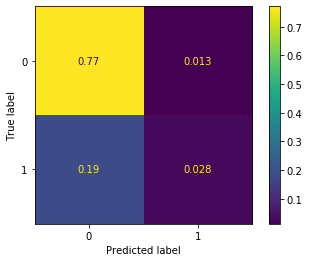

In [77]:
print(metrics.confusion_matrix(y_test, y_pred > .7))

# See https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix
disp = metrics.plot_confusion_matrix(model, X_test, y_test, normalize='all')
plt.show()

In [57]:
# See https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics
print(metrics.roc_auc_score(y_test, y_pred))

0.7342451044170506


# Train & score model - Method 2: xgboost's original "Learning" API

In [58]:
# Construct Data Matrix objects native to xgboost

# See https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.DMatrix
dm_train = xgb.DMatrix(X_train, label=y_train)
dm_test = xgb.DMatrix(X_test)

dm_train

In [71]:
# Train model
params = {
    'max_depth': 10,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'silent': 1
}

# See https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.train
%time lmodel = xgb.train(params, dm_train, num_boost_round=100)
print('Learning API model type:', type(lmodel))

CPU times: user 30.3 s, sys: 210 ms, total: 30.5 s
Wall time: 4.1 s
Learning API model type: <class 'xgboost.core.Booster'>


In [73]:
# Score Learning model

# See https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.predict
y_pred = lmodel.predict(dm_test)
y_pred

array([0.02233113, 0.04002302, 0.04369102, ..., 0.23244338, 0.09164319,
       0.06807289], dtype=float32)

In [74]:
print(metrics.confusion_matrix(y_test, y_pred>0.7))
print(metrics.roc_auc_score(y_test, y_pred))

[[78235   148]
 [20559  1058]]
0.7342451044170506


## Optional TODO: Train an `sklearn.ensemble.RandomForestClassifier` on the same data for performance comparison
- https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76